## Mounting drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing necessary libraries

In [ ]:
%%capture
%pip install datasets==1.18.3
%pip install transformers==4.17.0
%pip install jiwer

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
%%capture
!apt install git-lfs

## Prepare Data, Tokenizer, Feature Extractor

In [ ]:
from datasets import load_dataset, load_metric

librispeech_train = load_dataset("librispeech_asr", "clean")

Downloading:   0%|          | 0.00/2.40k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.82k [00:00<?, ?B/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/338M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/347M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/6.39G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/23.0G [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset librispeech_asr downloaded and prepared to /root/.cache/huggingface/datasets/librispeech_asr/clean/2.1.0/8c6e15bda76db687d2a7c7198808151adecbb4d890ff463033a2e6f788c0ba25. Subsequent calls will reuse this data.


  0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
librispeech = librispeech_train

In [ ]:
librispeech

DatasetDict({
    train.100: Dataset({
        features: ['file', 'audio', 'text', 'speaker_id', 'chapter_id', 'id'],
        num_rows: 28539
    })
    train.360: Dataset({
        features: ['file', 'audio', 'text', 'speaker_id', 'chapter_id', 'id'],
        num_rows: 104014
    })
    validation: Dataset({
        features: ['file', 'audio', 'text', 'speaker_id', 'chapter_id', 'id'],
        num_rows: 2703
    })
    test: Dataset({
        features: ['file', 'audio', 'text', 'speaker_id', 'chapter_id', 'id'],
        num_rows: 2620
    })
})

In [ ]:
librispeech_train = librispeech["train.100"]
librispeech_test = librispeech["test"]
librispeech_valid = librispeech["validation"]

In [ ]:
#sample dataset
librispeech_train

Dataset({
    features: ['file', 'audio', 'text', 'speaker_id', 'chapter_id', 'id'],
    num_rows: 28539
})

In [ ]:
librispeech_train = librispeech_train.remove_columns(["speaker_id", "chapter_id", "id"])
librispeech_testb = librispeech_test.remove_columns(["speaker_id", "chapter_id", "id"])
librispeech_validb = librispeech_valid.remove_columns(["speaker_id", "chapter_id", "id"])

In [ ]:
#sample dataset after removing columns
librispeech_train

Dataset({
    features: ['file', 'audio', 'text'],
    num_rows: 28539
})

In [ ]:
from datasets import ClassLabel
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)

    df = pd.DataFrame(dataset[picks])
    display(HTML(df.to_html()))

In [ ]:
show_random_elements(librispeech_train.remove_columns(["audio", "file"]), num_examples=10)

,text
0,FUSED IT AFRESH IN THE FIRE AND AT THIS WORK I SPENT MONTHS AND DAYS AS THE BADGER FINISHED SPEAKING THE PRIEST LOOKED AT THE MONEY WHICH IT HAD PRODUCED AND SURE ENOUGH HE SAW THAT IT WAS BRIGHT AND NEW AND CLEAN
1,MISSUS LOWDER HAD MADE DEAR MILLY THE TOPIC AND IT PROVED ON THE SPOT A TOPIC AS FAMILIAR TO THE ENTHUSIASTIC YOUNGER AS TO THE SAGACIOUS OLDER MAN ANY KNOWLEDGE THEY MIGHT LACK MISSUS LOWDER'S NIECE WAS MOREOVER ALERT TO SUPPLY
2,AND SOUGHT FOR SOME COOL SHADY PLACE TO REST HIS ACHING LIMBS HE CLIMBED TO THE TOP OF A HILL AND LAY DOWN IN THE GRASS AND AS HE THOUGHT UNDER THE SHADOW OF A BIG TREE
3,COULD NOT MASTER ME ALTOGETHER HE THEN TURNED TO THE HOLY SCRIPTURES BUT THEY APPEARED TO HIM INFERIOR IN STYLE TO CICERO MY PRIDE HE WRITES
4,TWELVE O'CLOCK PLACED HIM BEHIND HIM ON THE WHITE CHARGER AND HURRIED AWAY SO FAST THEY FLEW THAT BOBO WHO WAS HOLDING THE EBONY CASKET CLOSE AGAINST HIS HEART WAS IN GREAT DANGER OF FALLING OFF
5,TILL AT LAST HE GAVE OUT IN ALL THE FULNESS OF HIS LIQUID VOICE THEM ELEGANT LINES OUT OF POPE'S HOMER AS WHEN THE MOON REFULGENT LAMP OF NIGHT O'ER HEAVEN'S CLEAR AZURE SPREADS HER SACRED LIGHT
6,STRUCK ON HER AFFRIGHTED EAR HUMAN NATURE COULD SUPPORT NO MORE A COLD SWEAT STOOD ON HER FOREHEAD THE MANUSCRIPT FELL FROM HER HAND AND GROPING HER WAY TO THE BED SHE JUMPED HASTILY IN AND SOUGHT SOME SUSPENSION OF AGONY BY CREEPING FAR UNDERNEATH THE CLOTHES
7,AND CAROUSE WITH ME THIS NIGHT
8,WHAT A MAN FEELS A CHILD FEELS STILL MORE THE UNEASINESS OF NOCTURNAL FEAR INCREASED BY THE SPECTRAL HOUSES INCREASED THE WEIGHT OF THE SAD BURDEN UNDER WHICH HE WAS STRUGGLING
9,WHAT A LOOK OF YEARNING LOVE IT WAS THAT THE MILD GREY EYES TURNED ON THE STRONG DARK EYED MAN SHE DID NOT START AGAIN AT THE SIGHT OF HIM SHE SAID NOTHING BUT MOVED TOWARDS HIM SO THAT HIS ARM COULD CLASP HER ROUND


In [ ]:
import re
chars_to_ignore_regex = '[\,\?\.\!\-\;\:\"]'

def remove_special_characters(batch):
    batch["text"] = re.sub(chars_to_ignore_regex, '', batch["text"]).lower() + " "
    return batch

In [ ]:
librispeech_train = librispeech_train.map(remove_special_characters)
librispeech_test = librispeech_test.map(remove_special_characters)
librispeech_valid = librispeech_valid.map(remove_special_characters)

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

In [ ]:
show_random_elements(librispeech_train.remove_columns(["audio", "file"]))

,text
0,and many of them being separated by the violence of the shock they fell upon a crab tree which was growing below them they have like the farina of plants united and produced a fish resembling both
1,came very near ending as a complete cynic though in what f p a would call his lastline he managed to wriggle into a more hopeful mood the first valuable discovery that the colyumist is likely to make is that all minds are very much the same
2,consider sir how many thousands of medical students there are in this country no doubt there are many of them who have a difficulty in finding their fees am i to provide for them all or why should i make an exception in your favour i am grieved and disappointed mister montgomery
3,as may be imagined such a bath often resulted disastrously to the weak or sick the fact that the california indians could support themselves without any great exertion
4,they had been directed to the quarters of major jones in charge of the signal corps men in that section and it was with considerable surprise that the boys learned upon arriving there that they were to accompany the lieutenant into the superior officer's presence for instructions
5,i'll tell you how i know i've seen em i've done europe from soup to nuts they can't spring that stuff on jim blausser and get away with it and let me tell you that the only live thing in europe is our boys that are fighting there now london
6,and they certainly have good sense in choosing a house more sense than any other member of their family to my way of thinking but snake skins ugh by the way where does cresty build asked peter
7,and was only about his dinner his eyes over flowed but he shut his lips so tight that his mouth grew grim with determination and no more tears came to the friend who joined her at the church door and in george
8,miss tilney continuing silent she ventured to say her death must have been a great affliction a great and increasing one replied the other in a low voice
9,his eyes searched their faces they have told him nothing cried the girl tell me tell me cried graham you are the master of the earth you are owner of the world


In [ ]:
def extract_all_chars(batch):
  all_text = " ".join(batch["text"])
  vocab = list(set(all_text))
  return {"vocab": [vocab], "all_text": [all_text]}

In [ ]:
vocab_train = librispeech_train.map(extract_all_chars, batched=True, batch_size=-1, keep_in_memory=True, remove_columns=librispeech_train.column_names)
vocab_test = librispeech_test.map(extract_all_chars, batched=True, batch_size=-1, keep_in_memory=True, remove_columns=librispeech_test.column_names)
vocab_dev = librispeech_valid.map(extract_all_chars, batched=True, batch_size=-1, keep_in_memory=True, remove_columns=librispeech_valid.column_names)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
vocab_list = list(set(vocab_train["vocab"][0]) | set(vocab_dev["vocab"][0]) | set(vocab_test["vocab"][0]) )

In [ ]:
vocab_dict = {v: k for k, v in enumerate(vocab_list)}
vocab_dict

{'x': 0,
 ' ': 1,
 'c': 2,
 'h': 3,
 'g': 4,
 'b': 5,
 'q': 6,
 'u': 7,
 'a': 8,
 'f': 9,
 't': 10,
 'k': 11,
 'i': 12,
 'y': 13,
 "'": 14,
 'z': 15,
 'd': 16,
 'j': 17,
 'n': 18,
 'r': 19,
 'w': 20,
 's': 21,
 'l': 22,
 'o': 23,
 'e': 24,
 'm': 25,
 'v': 26,
 'p': 27}

In [ ]:
vocab_dict["|"] = vocab_dict[" "]
del vocab_dict[" "]

In [ ]:
vocab_dict["[UNK]"] = len(vocab_dict)
vocab_dict["[PAD]"] = len(vocab_dict)
len(vocab_dict)

30

In [ ]:
import json
with open('vocab_SST_high_accuracy.json', 'w') as vocab_file:
    json.dump(vocab_dict, vocab_file)

In [ ]:
from transformers import Wav2Vec2CTCTokenizer

tokenizer = Wav2Vec2CTCTokenizer("./vocab_SST_high_accuracy.json", unk_token="[UNK]", pad_token="[PAD]", word_delimiter_token="|")

### Create Wav2Vec2 Feature Extractor

In [ ]:
from transformers import Wav2Vec2FeatureExtractor

feature_extractor = Wav2Vec2FeatureExtractor(feature_size=1, sampling_rate=16000, padding_value=0.0, do_normalize=True, return_attention_mask=False)

In [ ]:
from transformers import Wav2Vec2Processor

processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)

## Saving tokenizer

In [ ]:
tokenizer.save_pretrained("/content/drive/MyDrive/Capstone-Lisa-Mimi")
files.download("/content/drive/MyDrive/Capstone-Lisa-Mimi")

tokenizer config file saved in /content/drive/MyDrive/Capstone-Lisa-Mimi/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/Capstone-Lisa-Mimi/special_tokens_map.json


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Preprocess data

In [ ]:
import numpy as np
np.object = np.object_


def prepare_dataset(batch):
    audio = batch["audio"]
    audio_array = np.array(audio["array"], dtype=np.float32)

    # Batched output is "un-batched" to ensure mapping is correct
    batch["input_values"] = processor(audio_array, sampling_rate=audio["sampling_rate"]).input_values[0]
    batch["input_length"] = len(batch["input_values"])

    with processor.as_target_processor():
        batch["labels"] = processor(batch["text"]).input_ids

    return batch

In [ ]:
librispeech_train = librispeech_train.map(prepare_dataset, remove_columns=librispeech_train.column_names)
librispeech_valid= librispeech_valid.map(prepare_dataset, remove_columns=librispeech_valid.column_names)
librispeech_test = librispeech_test.map(prepare_dataset, remove_columns=librispeech_test.column_names)

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

In [ ]:
max_input_length_in_sec = 4.0
train_dataset= librispeech_train.filter(lambda x: x < max_input_length_in_sec * processor.feature_extractor.sampling_rate, input_columns=["input_length"])

  0%|          | 0/29 [00:00<?, ?ba/s]

### Set-up Trainer

In [ ]:
import torch

from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union

@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
    """

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lenghts and need
        # different padding methods
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            return_tensors="pt",
        )
        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                return_tensors="pt",
            )

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        batch["labels"] = labels

        return batch

In [ ]:
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

In [ ]:
wer_metric = load_metric("wer")

Downloading:   0%|          | 0.00/1.90k [00:00<?, ?B/s]

In [ ]:
def compute_metrics(pred):
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)

    pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

    pred_str = processor.batch_decode(pred_ids)
    # we do not want to group tokens when computing the metrics
    label_str = processor.batch_decode(pred.label_ids, group_tokens=False)

    wer = wer_metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

In [ ]:
from transformers import Wav2Vec2ForCTC

model = Wav2Vec2ForCTC.from_pretrained(
    "facebook/wav2vec2-base",
    ctc_loss_reduction="mean",
    pad_token_id=processor.tokenizer.pad_token_id,
)

Downloading:   0%|          | 0.00/1.80k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/configuration_utils.py:356: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Downloading:   0%|          | 0.00/363M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
Some weights of the model checkpoint at facebook/wav2vec2-base were not used when initializing Wav2Vec2ForCTC: ['project_hid.bias', 'quantizer.codevectors', 'quantizer.weight_proj.weight', 'project_q.bias', 'project_hid.weight', 'quantizer.weight_proj.bias', 'project_q.weight']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model f

In [ ]:
model.freeze_feature_encoder()

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="/content/drive/MyDrive/Capstone-Lisa-Mimi",
  group_by_length=True,
  per_device_train_batch_size=32,
  per_device_eval_batch_size=32,
  evaluation_strategy="steps",
  num_train_epochs=10,
  fp16=True,
  gradient_checkpointing=True,
  save_steps=500,
  eval_steps=500,
  logging_steps=500,
  learning_rate=1e-4,
  weight_decay=0.005,
  warmup_steps=1000,
  save_total_limit=2,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=librispeech_train,
    eval_dataset=librispeech_valid,
    tokenizer=processor.feature_extractor,
)

Using amp half precision backend


## Training

In [ ]:
np.bool= np.bool_
trainer.train()

The following columns in the training set  don't have a corresponding argument in `Wav2Vec2ForCTC.forward` and have been ignored: input_length. If input_length are not expected by `Wav2Vec2ForCTC.forward`,  you can safely ignore this message.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 28539
  Num Epochs = 10
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 8920
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise a

Step,Training Loss,Validation Loss,Wer
500,3.617700,2.039361,0.901989
1000,0.385000,0.247597,0.217768
1500,0.150400,0.209368,0.198743
2000,0.113700,0.156193,0.145417


The following columns in the evaluation set  don't have a corresponding argument in `Wav2Vec2ForCTC.forward` and have been ignored: input_length. If input_length are not expected by `Wav2Vec2ForCTC.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2703
  Batch size = 32
Saving model checkpoint to /content/drive/MyDrive/Capstone-Lisa-Mimi/checkpoint-500
Configuration saved in /content/drive/MyDrive/Capstone-Lisa-Mimi/checkpoint-500/config.json
Model weights saved in /content/drive/MyDrive/Capstone-Lisa-Mimi/checkpoint-500/pytorch_model.bin
Feature extractor saved in /content/drive/MyDrive/Capstone-Lisa-Mimi/checkpoint-500/preprocessor_config.json
Deleting older checkpoint [/content/drive/MyDrive/Capstone-Lisa-Mimi/checkpoint-40] due to args.save_total_limit
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will 

Step,Training Loss,Validation Loss,Wer
500,3.617700,2.039361,0.901989
1000,0.385000,0.247597,0.217768
1500,0.150400,0.209368,0.198743
2000,0.113700,0.156193,0.145417
2500,0.093800,0.163230,0.140307
3000,0.078800,0.132644,0.134039
3500,0.073500,0.163447,0.146814
4000,0.063100,0.139539,0.132127
4500,0.059500,0.149405,0.127679
5000,0.051900,0.143245,0.127164


The following columns in the evaluation set  don't have a corresponding argument in `Wav2Vec2ForCTC.forward` and have been ignored: input_length. If input_length are not expected by `Wav2Vec2ForCTC.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2703
  Batch size = 32
Saving model checkpoint to /content/drive/MyDrive/Capstone-Lisa-Mimi/checkpoint-2500
Configuration saved in /content/drive/MyDrive/Capstone-Lisa-Mimi/checkpoint-2500/config.json
Model weights saved in /content/drive/MyDrive/Capstone-Lisa-Mimi/checkpoint-2500/pytorch_model.bin
Feature extractor saved in /content/drive/MyDrive/Capstone-Lisa-Mimi/checkpoint-2500/preprocessor_config.json
Deleting older checkpoint [/content/drive/MyDrive/Capstone-Lisa-Mimi/checkpoint-1500] due to args.save_total_limit
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we

TrainOutput(global_step=8920, training_loss=0.2798778080619504, metrics={'train_runtime': 33791.9944, 'train_samples_per_second': 8.445, 'train_steps_per_second': 0.264, 'total_flos': 3.324020727638998e+19, 'train_loss': 0.2798778080619504, 'epoch': 10.0})

In [ ]:
trainer.save_model("/content/drive/MyDrive/Capstone-Lisa-Mimi")

Saving model checkpoint to /content/drive/MyDrive/Capstone-Lisa-Mimi/trainer
Configuration saved in /content/drive/MyDrive/Capstone-Lisa-Mimi/trainer/config.json
Model weights saved in /content/drive/MyDrive/Capstone-Lisa-Mimi/trainer/pytorch_model.bin
Feature extractor saved in /content/drive/MyDrive/Capstone-Lisa-Mimi/trainer/preprocessor_config.json


## Plotting training and validation losses

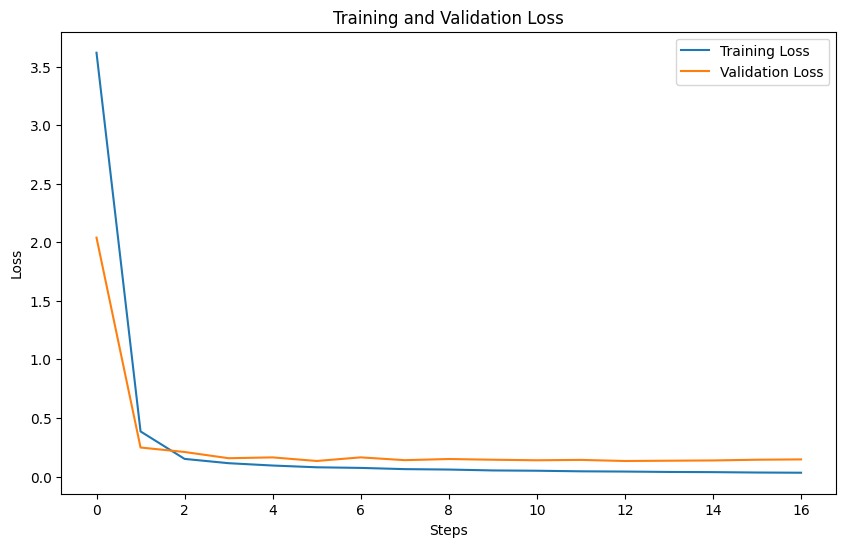

In [ ]:
import matplotlib.pyplot as plt

# Extract losses from the training log history
log_history = trainer.state.log_history

# Initialize lists to hold training and validation losses
training_loss = []
validation_loss = []

# Iterate through log history and extract losses
for log in log_history:
    if 'loss' in log:
        training_loss.append(log['loss'])
    if 'eval_loss' in log:
        validation_loss.append(log['eval_loss'])

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# saving model on my drive
model = Wav2Vec2ForCTC.from_pretrained("/content/drive/MyDrive/Capstone-Lisa-Mimi")
processor = Wav2Vec2Processor.from_pretrained("/content/drive/MyDrive/Capstone-Lisa-Mimi")

# Define the path where you want to save the final model
save_directory = "/content/drive/MyDrive/Capstone-Lisa-Mimi"

# Save the model and processor
model.save_pretrained(save_directory)
processor.save_pretrained(save_directory)

print(f"Model and processor saved in {save_directory}")

loading configuration file /content/drive/MyDrive/Capstone-Lisa-Mimi/config.json
Model config Wav2Vec2Config {
  "_name_or_path": "/content/drive/MyDrive/Capstone-Lisa-Mimi",
  "activation_dropout": 0.0,
  "adapter_kernel_size": 3,
  "adapter_stride": 2,
  "add_adapter": false,
  "apply_spec_augment": true,
  "architectures": [
    "Wav2Vec2ForCTC"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 1,
  "classifier_proj_size": 256,
  "codevector_dim": 256,
  "contrastive_logits_temperature": 0.1,
  "conv_bias": false,
  "conv_dim": [
    512,
    512,
    512,
    512,
    512,
    512,
    512
  ],
  "conv_kernel": [
    10,
    3,
    3,
    3,
    3,
    2,
    2
  ],
  "conv_stride": [
    5,
    2,
    2,
    2,
    2,
    2,
    2
  ],
  "ctc_loss_reduction": "mean",
  "ctc_zero_infinity": false,
  "diversity_loss_weight": 0.1,
  "do_stable_layer_norm": false,
  "eos_token_id": 2,
  "feat_extract_activation": "gelu",
  "feat_extract_norm": "group",
  "feat_proj_dropout": 0.1,
  "

Model and processor saved in /content/drive/MyDrive/Capstone-Lisa-Mimi/final_model


## Evaluation

In [ ]:
from transformers import AutoModelForCTC, Wav2Vec2Processor

model = AutoModelForCTC.from_pretrained("/content/drive/MyDrive/Capstone-Lisa-Mimi")
processor = Wav2Vec2Processor.from_pretrained("/content/drive/MyDrive/Capstone-Lisa-Mimi")

loading configuration file /content/drive/MyDrive/Capstone-Lisa-Mimi/config.json
Model config Wav2Vec2Config {
  "_name_or_path": "/content/drive/MyDrive/Capstone-Lisa-Mimi",
  "activation_dropout": 0.0,
  "adapter_kernel_size": 3,
  "adapter_stride": 2,
  "add_adapter": false,
  "apply_spec_augment": true,
  "architectures": [
    "Wav2Vec2ForCTC"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 1,
  "classifier_proj_size": 256,
  "codevector_dim": 256,
  "contrastive_logits_temperature": 0.1,
  "conv_bias": false,
  "conv_dim": [
    512,
    512,
    512,
    512,
    512,
    512,
    512
  ],
  "conv_kernel": [
    10,
    3,
    3,
    3,
    3,
    2,
    2
  ],
  "conv_stride": [
    5,
    2,
    2,
    2,
    2,
    2,
    2
  ],
  "ctc_loss_reduction": "mean",
  "ctc_zero_infinity": false,
  "diversity_loss_weight": 0.1,
  "do_stable_layer_norm": false,
  "eos_token_id": 2,
  "feat_extract_activation": "gelu",
  "feat_extract_norm": "group",
  "feat_proj_dropout": 0.1,
  "

In [ ]:
final_model = model.cuda()

In [ ]:
final_model

Wav2Vec2ForCTC(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder)

In [ ]:
def map_to_result(batch):
  with torch.no_grad():
    input_values = torch.tensor(batch["input_values"], device="cuda").unsqueeze(0)
    logits = model(input_values).logits

  pred_ids = torch.argmax(logits, dim=-1)
  batch["pred_str"] = processor.batch_decode(pred_ids)[0]
  batch["text"] = processor.decode(batch["labels"], group_tokens=False)

  return batch

In [ ]:
results = librispeech_test.map(map_to_result, remove_columns=librispeech_test.column_names)

0ex [00:00, ?ex/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,


In [ ]:
print("Test WER: {:.3f}".format(wer_metric.compute(predictions=results["pred_str"], references=results["text"])))

Test WER: 0.062


In [ ]:
show_random_elements(results)

,pred_str,text
0,a word should now be said about the origin of luther's commentary ungrelations,a word should now be said about the origin of luther's commentary on galatians
1,you have received us with all that courtesy and hospitality for which your character in england stands so high,you have received us with all that courtesy and hospitality for which your character in england stands so high
2,so we harried the coast of norway,so we harried the coast of norway
3,for many then this book has been a source of fascination surely one of the most influential novels ever written an inspiration for such scientists and discoverers as engineer simon lake osconographer william beb poler travelers are earnest schackleton,for many then this book has been a source of fascination surely one of the most influential novels ever written an inspiration for such scientists and discoverers as engineer simon lake oceanographer william beebe polar traveler sir ernest shackleton
4,tabby had tended them in their childhood they and none others should tend her in her infirmity and age,tabby had tended them in their childhood they and none other should tend her in her infirmity and age
5,mistress fitzouth had been carried off by the sheriff's daughter and her maids as soon as they had entered the house so that robin alone had the care of mont fishet,mistress fitzooth had been carried off by the sheriff's daughter and her maids as soon as they had entered the house so that robin alone had the care of montfichet
6,said captain dannithorne seating himself where he could see along the short passage to the open dirry door,said captain donnithorne seating himself where he could see along the short passage to the open dairy door
7,isn't he splendid cried jasper in intense pride swelling up father knew how to do it,isn't he splendid cried jasper in intense pride swelling up father knew how to do it
8,their diving stone poised on its rude supports and rocking under their plunges and the rugh hune stones of the sloping break water over which they scrambled in their horse play gleamed with cold wet lustre,their diving stone poised on its rude supports and rocking under their plunges and the rough hewn stones of the sloping breakwater over which they scrambled in their horseplay gleamed with cold wet lustre
9,see said uncas pointing north and south at the evident marks of the broad trail on either side of him the dark hair has gone towards the forest,see said uncas pointing north and south at the evident marks of the broad trail on either side of him the dark hair has gone toward the forest
